# Model Fitting with Threshold Artificial Neurons: Integrated Fire

In [1]:
import numpy as np
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Generate Data

In [2]:
duration = 100*ms
dt = 0.01 * ms
defaultclock.dt = dt
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(5*int(5*ms/dt))])* 5 * nA

In [3]:
C = 1*nF; gL = 30*nS; EL = -70*mV; VT = -50*mV; DeltaT = 2*mV
eqs = '''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    '''

In [4]:
start_scope()

In [5]:
I = TimedArray(input_current, dt=dt)

In [6]:
group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')

In [7]:
group.v = -70 *mV

In [8]:
monitor = StateMonitor(group, 'v', record=True)

In [9]:
run(duration)

In [10]:
voltage = monitor.v[0]/mV

In [11]:
voltage += np.random.randn(len(voltage))*1/2

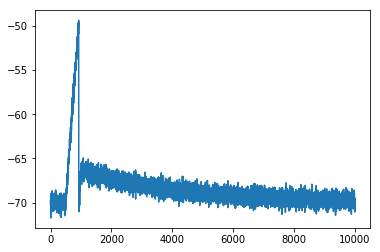

In [12]:
plot(voltage.transpose());

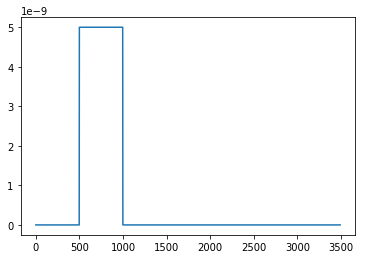

In [13]:
plot(input_current);

In [14]:
inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape

out_trace = np.array(voltage[:n1])


## Model Fitting

In [15]:
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    ''', 
    C = 1*nF, 
#     gL = 30*nS,
    EL = -70*mV, 
    VT = -50*mV, 
    DeltaT = 2*mV,  
    )

In [16]:
n_opt = NevergradOptimizer('DE')
metric = MSEMetric()

In [31]:
res, error = fit_traces_standalone(model=eqs_fit, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=[out_trace]*mV, dt=dt,
                                   param_init={'v': -70*mV},
                                   method='exponential_euler',
                                   gL=[1*nS, 100*nS],
                                   n_rounds=3, n_samples=30, optimizer=n_opt, 
                                   metric=metric,
                                   threshold='v > -50*mV', reset='v = -70*mV')


round 0 with error [0.00085526]
round 1 with error []
round 2 with error [0.00085522]


In [32]:
res

{'gL': 2.9984010015469994e-08}

In [33]:
fits = generate_fits(model=eqs_fit, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v':-70*mV},threshold='v > -50*mV', reset='v = -70*mV')

In [34]:
fits/mV

array([[-70.        , -69.99999997, -69.99999995, ..., -68.2896457 ,
        -68.29015839, -68.29067093]])

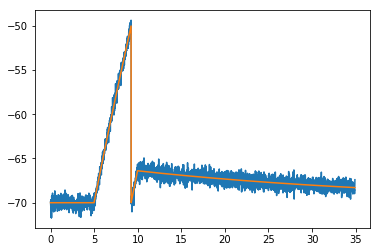

In [35]:
plot(np.arange(len(out_trace))*dt/ms, out_trace)
plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV)

### Two Parameters

In [38]:
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''', 
#     C = 1*nF, 
#     gL = 30*nS,
    EL = -70*mV, 
    VT = -50*mV, 
    DeltaT = 2*mV,  
    )

In [39]:
n_opt = NevergradOptimizer('DE')
metric = MSEMetric()

In [55]:
res, error = fit_traces_standalone(model=eqs_fit, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=[out_trace]*mV, dt=dt,
                                   param_init={'v': -70*mV},
                                   method='exponential_euler',
                                   gL=[1*nS, 100*nS],
                                   C=[0.1*nF, 10*nF],
                                   n_rounds=3, n_samples=30, optimizer=n_opt, 
                                   metric=metric,
                                   threshold='v > -50*mV', reset='v = -70*mV')


round 0 with error [0.04344894 0.04344894]
round 1 with error [0.04279191 0.04279191]
round 2 with error [0.04268732 0.04268732]


In [56]:
res

{'gL': 9.255872581429116e-08, 'C': 5.592759798734818e-09}

In [57]:
fits = generate_fits(model=eqs_fit, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v':-70*mV},threshold='v > -50*mV', reset='v = -70*mV')

In [58]:
fits/mV

array([[-70.        , -69.99999998, -69.99999997, ..., -67.16499433,
        -67.16546342, -67.16593242]])

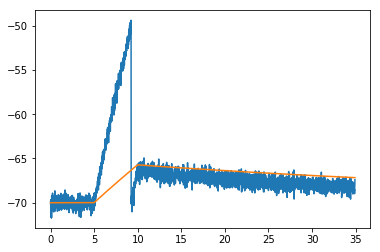

In [59]:
plot(np.arange(len(out_trace))*dt/ms, out_trace)
plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV)

## Not C!

In [67]:
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    EL:  volt (constant)
    VT: volt (constant)
    ''', 
    C = 1*nF, 
#     gL = 30*nS,
#     EL = -70*mV, 
#     VT = -50*mV, 
    DeltaT = 2*mV,  
    )

In [68]:
n_opt = NevergradOptimizer('DE')
metric = MSEMetric()

In [69]:
res, error = fit_traces_standalone(model=eqs_fit, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=[out_trace]*mV, dt=dt,
                                   param_init={'v': -70*mV},
                                   method='exponential_euler',
                                   gL=[1*nS, 100*nS],
                                   EL=[-100*mV, 0*mV],
                                   VT=[-100*mV, 0*mV],
                                   n_rounds=3, n_samples=30, optimizer=n_opt, 
                                   metric=metric,
                                   threshold='v > -50*mV', reset='v = -70*mV')


round 0 with error [0.00495569 0.00495569 0.00495569]
round 1 with error [0.00495434 0.00495434 0.00495434]
round 2 with error [0.00333336 0.00333336 0.00333336]


In [70]:
res

{'gL': 2.243180142311169e-08,
 'EL': -0.07260360433369341,
 'VT': -0.01940656784241067}

In [71]:
fits = generate_fits(model=eqs_fit, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v':-70*mV},threshold='v > -50*mV', reset='v = -70*mV')

In [72]:
fits/mV

array([[-70.        , -70.00058397, -70.00116781, ..., -69.18032498,
        -69.18109279, -69.18186044]])

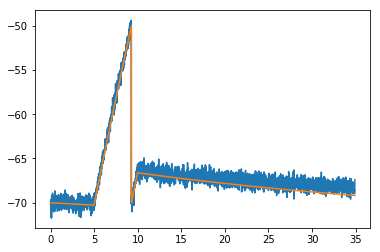

In [73]:
plot(np.arange(len(out_trace))*dt/ms, out_trace)
plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV)